# **Notebooks With NuoDB**
#Introduction

This Notebook is intended as a demo of using Jupyter Notebook style applications with NuoDB.

Databases like NuoDB excel in storing large amounts of structured data. However one needs to be knowledgeable of SQL to analyze the data. Motebooks provide a powerful abstraction of the data stored in databases and combine it with simplicity and power of Python.

In this notebook we explore the following topics:
1. Connecting to Colab Research Notebooks
2. Installing Python on your local machine and why do we need it
3. Connecting to NuoDB
4. Building Pandas DataFrame
5. Creating a DataFrame from NuoDB Table
6. Exploring Sample Hockey Database with Pandas
7. Visualizing Data with Pandas
8. Applying Statistics

# Connecting to Colab Research Notebooks
To start, make your own copy of this notebook so you can work with it. To make the copy press "***Open in Colab***" button on the first line of this document. Note, that I checked that Firefox and Chrome work correctly with Colab.  

Here is a bit of background on Notebooks and Colab....

Colab (see [here](https://colab.research.google.com/)) is a free Jupyter Notebook (see [here](https://en.wikipedia.org/wiki/Project_Jupyter)) hosted by Google Research. 

Colab provides a simplified Notebook UI. It is fully cloud-based and allows you to share documents and collaborate effortlessly.

Try it for 10 minutes yourself - [try me](https://colab.research.google.com/).
What do you think ? 😃

Now we can try something simple in this Notebook. Go to the next block (aka Cell) and press *Play* button in the upper left corner... 

In [4]:
myString = "Notebook is Up and Running"
print(myString)

Notebook is Up and Running


The Code Cell should execute and produce an output string like this:

`Notebook is Up and Running`

# Installing Python on your local machine and why do we need it

While Colab is cloud-based, we have to run a Jupyter server locally and have Python installed in order to connect to a NuoDB database. This makes sense because we will be using NuoDB Python client (*nuopy*) to connect.

This is actually quite easy.

First install Python3 on your machine. Here are options for Windows, MacOS and Linux - [python.org/downloads/](https://www.python.org/downloads/)

Then use Python PIP (Preferred Installer Program) to install Jupyter:

`$ pip install notebook`

Note, this worked for me on MacOS. Let me know if it does NOT work the same way on Windows or Linux (boris.BULANOV@3DS.com)

The next step is to start the Jupyter Notebook server locally and authorize it to allow Colab to use it. This is described in detail [here](https://research.google.com/colaboratory/local-runtimes.html), but really comes down to the following steps:

```
$ pip install jupyter_http_over_ws
$ jupyter serverextension enable --py jupyter_http_over_ws
$ jupyter notebook \
  --NotebookApp.allow_origin='https://colab.research.google.com' \
  --port=8888 \
  --NotebookApp.port_retries=0

```

And now we are ready to connect Colab to the local Jupyter server.
In Colab UI, pull down the Connect drop menu (upper right corner). Select the "Connect to local runtime" option. Another menu appears. Grab the URL from Jupyter server startup and paste it in the dialog box. Click "Connect" button and you are ready to rock.

By the way, you can always get the same Jupyter server URL with the following command:

`$ jupyter notebook list`

Now we are running Colab in the cloud, but the Python client is executing on the local machine - VERY cool!





# Connecting to NuoDB

At this point you need access to a NuoDB database. It can be local on your machine or remote with access enabled. The easiest way to check for accessibility is to run *nuosql* command. For example:

`$ nuosql demo --user dba --password dba`

We then should install *nuopy* package for Python:

`$ pip install pynuodb`

For more detail and additional options for NuoDB Python driver installation read [here](https://github.com/nuodb/nuodb-python).

And now we are ready to check NuoDB access from Colab. Look at the next Cell at the sample code... BTW, change connection properties (database name, host, username, passowrd) to fit your NuoDB credentials. 

And now you can press the play button on the cell below :


In [3]:
import pynuodb

connection = pynuodb.connect("demo","localhost:48004","dba","dba",{"schema": "user"})
cursor = connection.cursor()

cursor.execute("SELECT * FROM system.nodes")

for row in cursor.fetchall():
        print(row)

cursor.close()
connection.close()

(1, 0, 1, 48006, '172.19.0.4', 'sm1', 'Running', 'Storage', 'Ready', 0, 371, '0', '4.1|4.1.1|4.1.2', 'NONE', 1376256, '4.1.2.vee-4-04ce73dcdc', '')
(2, 1, 0, 48006, '10.34.240.179', '10.34.240.179', 'Running', 'Transaction', 'Ready', 0, 0, '0', '', 'NONE', 1376256, '4.1.2.vee-4-04ce73dcdc', 'Vectorized')


If the connection is successful, we will see information about available NuoDB nodes for the database.  

# Building Pandas DataFrame

Python comes with a large number of libraries (aka packages) that make complex data processing tasks easy. One of such packages is called Pandas. 

Key building block of Pandas is a structure called *DataFrame*. DataFrame is a two dimensional array with a lot of convenience function defined to operate on rows, columns and cells. Pandas also used to prepare data for visualization - tables, charts, and graphs. Take a look at usage patterns for Pandas [here
](https://pandas.pydata.org/docs/user_guide/).

Let's try creating a DataFrame and run a few operations with it. Press *Play* button below to execute the samples one by one:


In [4]:
# import pandas
import pandas as pd

# create a DataFrame as Array or Arrays
df = pd.DataFrame([[1, 2, 3], [4, 5, 6],[7, 8, 9]],columns=["a","b","c"])

# print the DatFrame
print("DataFrame: \n",df)


DataFrame: 
    a  b  c
0  1  2  3
1  4  5  6
2  7  8  9


In [5]:
# find max value of column "c"
print("Max Value of column \"c\": ",df.c.max())

Max Value of column "c":  9


In [6]:
# add values of columns "a" and "b" into a new column "d"
df["d"] = df.a + df.b
print("DataFrame with the new column \"d\"\n",df)

DataFrame with the new column "d"
    a  b  c   d
0  1  2  3   3
1  4  5  6   9
2  7  8  9  15


See how easy, intuitive and powerful these simple operations are with DataFrames!!!

# Creating a DataFrame from a NuoDB Table
DataFrames allow for importing data from multiple sources very easily - CSV and delimited files, excel. You can also import data from SQL, but that requires an ORM package called *SQLAlchemy*.

We will take a simpler approach and provide a python function for populating a DataFrame from NuoDB.

The function is called *create_dataframe_from_table* and takes the following parameters:
*   connection - connection to a database
*   table_name - database table name to build the DataFrame
*   columns - a list of columns to build the DataFrame with 
*   limit - number of rows to return from database. Defaults to 5 rows






In [7]:
#@title Function to populate a Panda DataFrame from a SQL Table


def create_dataframe_from_table(connection,table_name,columns,limit=5):
  df = pd.DataFrame()
  df1 = pd.DataFrame()
  cursor = connection.cursor()

  statement = "select " + ','.join(columns) + " from " + table_name + " limit " + str(limit)
  #print("DEBUG: ",statement)

  try:
      cursor.execute(statement)
      for row in cursor.fetchall():
         i = 0;
         for column in columns:
            df1[column] = [row[i]]
            i = i + 1;
         df = pd.concat([df,df1])
  finally:
    cursor.close()
  return df;

Let's try the function. Note that you need to execute the function definition above (press *Play* button) in order for the function to be available.  

In [8]:
connection = pynuodb.connect("demo","localhost:48004","dba","dba",{"schema": "user"})

df2 = create_dataframe_from_table(connection,"system.nodes",("Port","Address","Hostname","Triptime"))
print(df2)

connection.close()

    Port        Address       Hostname  Triptime
0  48006     172.19.0.4            sm1       227
0  48006  10.34.240.179  10.34.240.179         0


# Exploring Sample Hockey Database with Pandas
NuoDB installation comes with a sample Hockey database. Assuming that NuoDB instaled at */opt/nuodb* directory, you can use the following commands to populate the database (adjust database name and credentials, of course):
```
/opt/nuodb/bin/nuosql demo --user dba --password dba </opt/nuodb/samples/quickstart/sql/create-db.sql
/opt/nuodb/bin/nuosql demo --user dba --password dba </opt/nuodb/samples/quickstart/sql/Players.sql
/opt/nuodb/bin/nuosql demo --user dba --password dba </opt/nuodb/samples/quickstart/sql/Scoring.sql
/opt/nuodb/bin/nuosql demo --user dba --password dba </opt/nuodb/samples/quickstart/sql/Teams.sql
```

Let's create a DataFrame for Teams table and explore....



In [9]:
# Create a DataFrame 
connection = pynuodb.connect("demo","localhost:48004","dba","dba",{"schema": "user"})

table_name = "teams"
columns = ("year","teamid","name","games","wins")

df_teams = create_dataframe_from_table(connection,table_name,columns,1519)

connection.close()


In [10]:
# What is the number of rows and columns in the DataFrame
df_teams.shape

(1519, 5)

In [11]:
# Print first few rows of the DataFrame
print(df_teams.head())

   year teamid                    name  games  wins
0  1909    COB     Cobalt Silver Kings     12     4
0  1909    HAI  Haileybury Hockey Club     12     4
0  1909    LES           Les Canadiens     12     2
0  1909    MOS      Montreal Shamrocks     12     3
0  1909    MOW      Montreal Wanderers     12    11


In [12]:
# Show teams that played the longest
most_years = df_teams["name"].value_counts().nlargest(5)
print("Teams played for most years:\n",most_years)

Teams played for most years:
 Montreal Canadiens     101
Boston Bruins           87
New York Rangers        85
Toronto Maple Leafs     84
Detroit Red Wings       79
Name: name, dtype: int64


# Visualizing Data with Pandas
Let's see how Pandas allow us to visualize data easily. For this we may use plotting package *matplotlib*.


Text(0.5, 1.0, 'Percentage of Games Won over the Years')

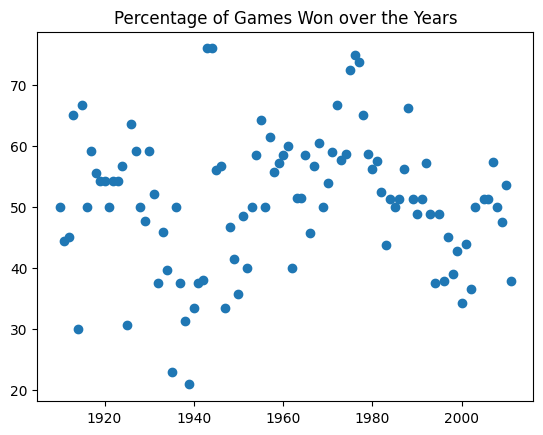

In [13]:
import matplotlib.pyplot as plt

# Create a DataFrame with all "Montreal Canadiens" rows
montreal_df = df_teams.query('name == "Montreal Canadiens"')
# print(montreal_df.head())

# Explore percentage of "wins" over the years 
x_axis = montreal_df["year"]
y_axis = montreal_df["wins"]/montreal_df["games"]*100

plt.scatter(x_axis,y_axis)
plt.title("Percentage of Games Won over the Years")


*italicized text*# Applying Statistics
In addition to plotting data, we can start applying multiple statistical functions available in *Scipy Stats* package - [here
](https://pythonguides.com/scipy-stats/). Note that you may need to install *scipy* package on your local machine before running this example.

In this example we will try *linear regression* function - [here](https://docs.scipy.org/doc/scipy-1.6.2/reference/generated/scipy.stats.linregress.html). The function defines a line that fits our data trend. It returns a number of statistical parameters of which we are interested in *slope* and *intercept*. Having these values, we can enhance our plot:

Text(0.5, 1.0, 'Percentage of Games Won over the Years')

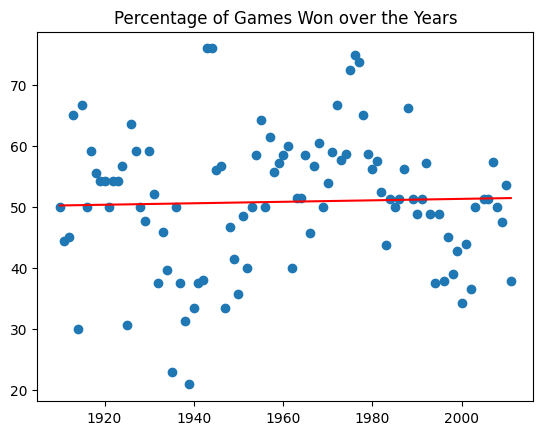

In [14]:
import scipy
from scipy import stats


slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis,y_axis)

plt.scatter(x_axis,y_axis)
plt.plot(x_axis, slope*x_axis+intercept, 'r-')
plt.title("Percentage of Games Won over the Years")


The red line represents the winning trend of the team, "*Montreal Canadiens*", over the years. As we can see, the team winning ratio is slighly improving over the years but not in a significant way.

Can we find a team that improved the most? 

A few lines of code below help us do exactly that. Note that we want to set a floor of home many seasons the team should play in order for the data be valueable. The example sets it to 10, but try changing the number and see the effects.

In [15]:
minimum_years_played = 10

most_improving_team = ''
most_improving_slope = -100

for team in df_teams["name"]:
  temp_df = df_teams.query("name == @team")
  if (temp_df.shape[0] < minimum_years_played):
    continue

  x = temp_df["year"]
  y = temp_df["wins"]/temp_df["games"]*100
  slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
  
  if (slope > most_improving_slope):
      most_improving_slope = slope
      most_improving_team = team
  
print("Most improving team: ",most_improving_team,", slope = ",most_improving_slope,", seasons played = ",temp_df.shape[0])


Most improving team:  Atlanta Thrashers , slope =  2.114338977784682 , seasons played =  25


If the *minimum_years_played* is set to 10, then the winning team is "Atlanta Thrashers". And we can plot the line as before to see how it fits the data.

Text(0.5, 1.0, 'Percentage of Games Won by Atlanta Thrashers')

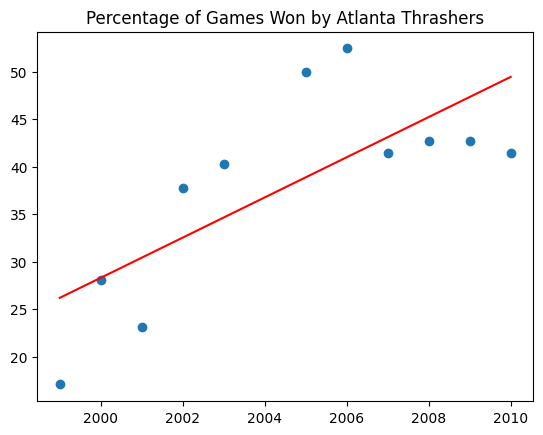

In [16]:
# Create a 
win_df = df_teams.query('name == @most_improving_team')

x = win_df["year"]
y = win_df["wins"]/win_df["games"]*100
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

plt.plot(x, slope*x+intercept, 'r-')
plt.scatter(x,y)
plt.title("Percentage of Games Won by " + most_improving_team)

In this case we can see the winning trend and can reason about the past as well as try to predict future results.  

# Conclusion
Notebooks provide NuoDB users with a new mechanisms to explore and visualize data in the database. It can be used by adminstrators, users, and data scientists. 

It can be used to create tutorials, documentations and demos. Let us explore!
